In [3]:
import string
import re
from numpy import array, argmax, take, random
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [5]:
#Function to read raw text file
def read_text(filename):
  file = open(filename, mode='rt', encoding='utf-8')
  text = file.read()
  file.close()
  return text

In [6]:
#Function to split the text into sentences
def split_text(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [17]:
text = read_text('/content/drive/MyDrive/Datasets/GER-ENG Translation dataset - Seq2Seq with LSTM/deu.txt')
sents = split_text(text)
sents = array(sents)

In [18]:
deu_eng = sents[:50000, :]

Text Preprocessing

In [19]:
deu_eng[:, 0] = [ s.translate(str.maketrans('','',string.punctuation)) for s in deu_eng[:, 0]]
deu_eng[:, 1] = [ s.translate(str.maketrans('','',string.punctuation)) for s in deu_eng[:, 1]]
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Im giving up smoking', 'Ich höre mit dem Rauchen auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256952 (minshirui) & #407184 (MUIRIEL)'],
       ['Im glad I was nearby', 'Ich bin froh dass ich in der Nähe war',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547219 (CK) & #3448316 (Pfirsichbaeumchen)'],
       ['Im glad Tom has gone', 'Ich bin froh dass Tom weg ist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547217 (CK) & #5299642 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [20]:
for i in range(len(deu_eng)):
  deu_eng[i,0] = deu_eng[i,0].lower()
  deu_eng[i,1] = deu_eng[i,1].lower()

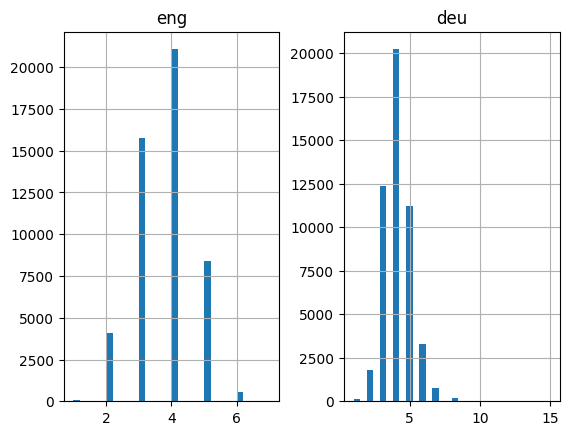

In [21]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()


In [23]:
#Build a tokenization model for the particular language texts
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [24]:
#Build the tokenization model for English Vocabulary

eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print(f'The vocabulary size of the english words is {eng_vocab_size}')

The vocabulary size of the english words is 6256


In [25]:
#Build the tokenization model for German Vocabulary
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print(f'The vocabulary size of the deutche words is {deu_vocab_size}')

The vocabulary size of the deutche words is 10329


In [27]:
#Encode Pad Sequences
def encode_text(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)

  #Encode with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [28]:
from sklearn.model_selection import train_test_split

#split data into train and test data
train, test = train_test_split(deu_eng, test_size=0.2, random_state=42)

In [29]:
#Encode the sentences and prepare train and test data
trainX = encode_text(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_text(eng_tokenizer, eng_length, train[:, 0])

testX = encode_text(deu_tokenizer, deu_length, test[:, 1])
testY = encode_text(eng_tokenizer, eng_length, test[:, 0])

Define the Model

In [36]:
#build NMT model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [37]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [38]:
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [39]:
filename = 'model.h1.Jun_11_23'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split=0.2, callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.4117
Epoch 1: val_loss improved from inf to 2.80647, saving model to model.h1.Jun_11_23


63/63 [==============================] - 393s 6s/step - loss: 3.4117 - val_loss: 2.8065
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.7748
Epoch 2: val_loss improved from 2.80647 to 2.73890, saving model to model.h1.Jun_11_23


63/63 [==============================] - 345s 6s/step - loss: 2.7748 - val_loss: 2.7389
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.6025
Epoch 3: val_loss improved from 2.73890 to 2.57969, saving model to model.h1.Jun_11_23


63/63 [==============================] - 316s 5s/step - loss: 2.6025 - val_loss: 2.5797
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.4280
Epoch 4: val_loss improved from 2.57969 to 2.41831, saving model to model.h1.Jun_11_23


63/63 [==============================] - 298s 5s/step - loss: 2.4280 - val_loss: 2.4183
Epoch 5/30
63/63 [==============================] - ETA: 0s - loss: 2.2963
Epoch 5: val_loss improved from 2.41831 to 2.33575, saving model to model.h1.Jun_11_23


63/63 [==============================] - 301s 5s/step - loss: 2.2963 - val_loss: 2.3357
Epoch 6/30
63/63 [==============================] - ETA: 0s - loss: 2.1688
Epoch 6: val_loss improved from 2.33575 to 2.21728, saving model to model.h1.Jun_11_23


63/63 [==============================] - 296s 5s/step - loss: 2.1688 - val_loss: 2.2173
Epoch 7/30
63/63 [==============================] - ETA: 0s - loss: 2.0447
Epoch 7: val_loss improved from 2.21728 to 2.15578, saving model to model.h1.Jun_11_23


63/63 [==============================] - 296s 5s/step - loss: 2.0447 - val_loss: 2.1558
Epoch 8/30
63/63 [==============================] - ETA: 0s - loss: 1.9304
Epoch 8: val_loss improved from 2.15578 to 2.05664, saving model to model.h1.Jun_11_23


63/63 [==============================] - 307s 5s/step - loss: 1.9304 - val_loss: 2.0566
Epoch 9/30
63/63 [==============================] - ETA: 0s - loss: 1.8191
Epoch 9: val_loss improved from 2.05664 to 1.96554, saving model to model.h1.Jun_11_23


63/63 [==============================] - 293s 5s/step - loss: 1.8191 - val_loss: 1.9655
Epoch 10/30
63/63 [==============================] - ETA: 0s - loss: 1.7162
Epoch 10: val_loss improved from 1.96554 to 1.88408, saving model to model.h1.Jun_11_23


63/63 [==============================] - 305s 5s/step - loss: 1.7162 - val_loss: 1.8841
Epoch 11/30
63/63 [==============================] - ETA: 0s - loss: 1.6175
Epoch 11: val_loss improved from 1.88408 to 1.81538, saving model to model.h1.Jun_11_23


63/63 [==============================] - 289s 5s/step - loss: 1.6175 - val_loss: 1.8154
Epoch 12/30
63/63 [==============================] - ETA: 0s - loss: 1.5258
Epoch 12: val_loss improved from 1.81538 to 1.79419, saving model to model.h1.Jun_11_23


63/63 [==============================] - 290s 5s/step - loss: 1.5258 - val_loss: 1.7942
Epoch 13/30
63/63 [==============================] - ETA: 0s - loss: 1.4391
Epoch 13: val_loss improved from 1.79419 to 1.70582, saving model to model.h1.Jun_11_23


63/63 [==============================] - 306s 5s/step - loss: 1.4391 - val_loss: 1.7058
Epoch 14/30
63/63 [==============================] - ETA: 0s - loss: 1.3516
Epoch 14: val_loss improved from 1.70582 to 1.66499, saving model to model.h1.Jun_11_23


63/63 [==============================] - 289s 5s/step - loss: 1.3516 - val_loss: 1.6650
Epoch 15/30
63/63 [==============================] - ETA: 0s - loss: 1.2719
Epoch 15: val_loss improved from 1.66499 to 1.61048, saving model to model.h1.Jun_11_23


63/63 [==============================] - 292s 5s/step - loss: 1.2719 - val_loss: 1.6105
Epoch 16/30
63/63 [==============================] - ETA: 0s - loss: 1.1955
Epoch 16: val_loss improved from 1.61048 to 1.57562, saving model to model.h1.Jun_11_23


63/63 [==============================] - 307s 5s/step - loss: 1.1955 - val_loss: 1.5756
Epoch 17/30
63/63 [==============================] - ETA: 0s - loss: 1.1211
Epoch 17: val_loss improved from 1.57562 to 1.54927, saving model to model.h1.Jun_11_23


63/63 [==============================] - 289s 5s/step - loss: 1.1211 - val_loss: 1.5493
Epoch 18/30
63/63 [==============================] - ETA: 0s - loss: 1.0504
Epoch 18: val_loss improved from 1.54927 to 1.48994, saving model to model.h1.Jun_11_23


63/63 [==============================] - 307s 5s/step - loss: 1.0504 - val_loss: 1.4899
Epoch 19/30
63/63 [==============================] - ETA: 0s - loss: 0.9842
Epoch 19: val_loss improved from 1.48994 to 1.48124, saving model to model.h1.Jun_11_23


63/63 [==============================] - 308s 5s/step - loss: 0.9842 - val_loss: 1.4812
Epoch 20/30
63/63 [==============================] - ETA: 0s - loss: 0.9198
Epoch 20: val_loss improved from 1.48124 to 1.42889, saving model to model.h1.Jun_11_23


63/63 [==============================] - 307s 5s/step - loss: 0.9198 - val_loss: 1.4289
Epoch 21/30
63/63 [==============================] - ETA: 0s - loss: 0.8580
Epoch 21: val_loss improved from 1.42889 to 1.41076, saving model to model.h1.Jun_11_23


63/63 [==============================] - 310s 5s/step - loss: 0.8580 - val_loss: 1.4108
Epoch 22/30
63/63 [==============================] - ETA: 0s - loss: 0.7979
Epoch 22: val_loss improved from 1.41076 to 1.39627, saving model to model.h1.Jun_11_23


63/63 [==============================] - 306s 5s/step - loss: 0.7979 - val_loss: 1.3963
Epoch 23/30
63/63 [==============================] - ETA: 0s - loss: 0.7426
Epoch 23: val_loss improved from 1.39627 to 1.38464, saving model to model.h1.Jun_11_23


63/63 [==============================] - 289s 5s/step - loss: 0.7426 - val_loss: 1.3846
Epoch 24/30
63/63 [==============================] - ETA: 0s - loss: 0.6867
Epoch 24: val_loss improved from 1.38464 to 1.35494, saving model to model.h1.Jun_11_23


63/63 [==============================] - 293s 5s/step - loss: 0.6867 - val_loss: 1.3549
Epoch 25/30
63/63 [==============================] - ETA: 0s - loss: 0.6386
Epoch 25: val_loss improved from 1.35494 to 1.34011, saving model to model.h1.Jun_11_23


63/63 [==============================] - 308s 5s/step - loss: 0.6386 - val_loss: 1.3401
Epoch 26/30
63/63 [==============================] - ETA: 0s - loss: 0.5882
Epoch 26: val_loss did not improve from 1.34011
63/63 [==============================] - 279s 4s/step - loss: 0.5882 - val_loss: 1.3611
Epoch 27/30
63/63 [==============================] - ETA: 0s - loss: 0.5435
Epoch 27: val_loss improved from 1.34011 to 1.33066, saving model to model.h1.Jun_11_23


63/63 [==============================] - 291s 5s/step - loss: 0.5435 - val_loss: 1.3307
Epoch 28/30
63/63 [==============================] - ETA: 0s - loss: 0.5026
Epoch 28: val_loss improved from 1.33066 to 1.30371, saving model to model.h1.Jun_11_23


63/63 [==============================] - 310s 5s/step - loss: 0.5026 - val_loss: 1.3037
Epoch 29/30
63/63 [==============================] - ETA: 0s - loss: 0.4606
Epoch 29: val_loss improved from 1.30371 to 1.29287, saving model to model.h1.Jun_11_23


63/63 [==============================] - 319s 5s/step - loss: 0.4606 - val_loss: 1.2929
Epoch 30/30
63/63 [==============================] - ETA: 0s - loss: 0.4248
Epoch 30: val_loss improved from 1.29287 to 1.28593, saving model to model.h1.Jun_11_23


63/63 [==============================] - 315s 5s/step - loss: 0.4248 - val_loss: 1.2859


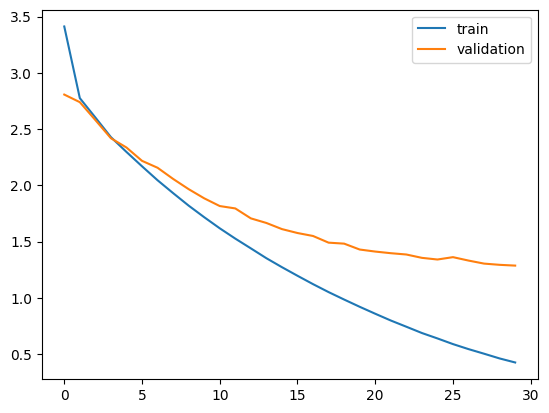

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

In [42]:
preds = model.predict(testX.reshape(testX.shape[0], testX.shape[1]))

313/313 [==============================] - 42s 127ms/step


In [43]:
def get_word(n, tokenizer):
  for word, i in tokenizer.word_index.items():
    if i == n:
      return word
  return None

In [49]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
      print(f'Word is {i}')
      t = get_word(i[j], eng_tokenizer)
      if j > 0:
          if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
              temp.append('')
          else:
              temp.append(t)
      else:
          if(t == None):
              temp.append('')
          else:
              temp.append(t) 

    preds_text.append(' '.join(temp))

Word is [[8.8430752e-05 9.5902424e-06 8.0141085e-08 ... 7.3271018e-08
  2.1746938e-08 4.3546087e-09]
 [6.3758355e-04 1.4586595e-01 4.4240272e-07 ... 3.8322981e-10
  3.8868055e-08 3.3388319e-09]
 [1.7267579e-02 4.7387616e-03 4.6187577e-07 ... 3.9117660e-09
  2.6672277e-08 1.1920142e-08]
 ...
 [9.9958879e-01 2.5025967e-05 3.2084582e-09 ... 3.7098870e-15
  1.7543313e-13 5.7829643e-14]
 [9.9997658e-01 1.2415734e-06 1.0479178e-09 ... 7.2765102e-18
  4.6880855e-15 8.0067658e-16]
 [9.9999160e-01 3.9269315e-07 1.0082724e-09 ... 6.0966318e-19
  2.1173698e-15 3.0168360e-16]]


ValueError: ignored

In [ ]:
pred_df = pd.DataFrame({'actual':test[:, 0], 'predicted':test[:,1]})
pred_df.head(15)